<a href="https://colab.research.google.com/github/Rahullnitp/Mri_Brain/blob/master/MRI_Brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    2GB  2020-05-02 20:35:01          63398  
divyansh22/us-border-crossing-data                          US Border Crossing Data                               2MB  2020-04-19 09:38:10           1456  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          142MB  2020-04-29 22:47:23           7563  
baltacifatih/turkish-lira-banknote-dataset                  Turkish Lira Banknote Dataset                         3GB  2020-04-19 14:48:39            132  
doaaalsenani/usa-cers-dataset                               US C

In [7]:
!kaggle datasets list -s brain

ref                                                          title                                             size  lastUpdated          downloadCount  
-----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
mateuszbuda/lgg-mri-segmentation                             Brain MRI segmentation                           714MB  2019-05-02 21:32:45           5016  
navoneel/brain-mri-images-for-brain-tumor-detection          Brain MRI Images for Brain Tumor Detection        15MB  2019-04-14 15:15:54           8778  
usharengaraju/crimeagainstwomen                              sRNA sequencing - Brain (GSE75140)                25MB  2020-04-05 16:03:10            153  
wanghaohan/confused-eeg                                      Confused student EEG brainwave data              109MB  2018-03-28 20:52:52           5387  
berkeley-biosense/synchronized-brainwave-dataset             Synchronized Br

In [8]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 79% 12.0M/15.1M [00:00<00:00, 123MB/s]
100% 15.1M/15.1M [00:00<00:00, 96.3MB/s]


In [0]:
from IPython.display import clear_output
!pip install imutils
clear_output()


In [0]:
import numpy as np
import pandas as pd


In [0]:
# data=pd.read_csv("/content/brain-mri-images-for-brain-tumor-detection.zip")
# df = pd.read_csv("/path/to/file.csv.zip")

In [0]:
from zipfile import ZipFile

In [0]:
ext=["jpg","jpeg"]

In [0]:
with ZipFile('/content/brain-mri-images-for-brain-tumor-detection.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   listOfFileNames = zipObj.namelist()
   # Iterate over the file names
   for fileName in listOfFileNames:
       # Check filename endswith jpg
       if fileName.endswith(tuple(ext)):
           # Extract a single file from zip
           zipObj.extract(fileName, 'temp_csv')

In [0]:
!rm -rf /content/temp_csv/no   #for removing the extra folder
!rm -rf /content/temp_csv/yes

In [16]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── sample_data
├── temp_csv
│   └── brain_tumor_dataset
│       ├── no
│       └── yes
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

14 directories


In [0]:
import os
import shutil

In [0]:
IMG_PATH = '/content/temp_csv/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [0]:
from tqdm import tqdm
import cv2

In [0]:
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [21]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00, 13.08it/s]

132 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
35 images loaded from VAL/ directory.


In [0]:
import imutils

In [0]:
import matplotlib.pyplot as plt


In [0]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [0]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

In [0]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 5
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

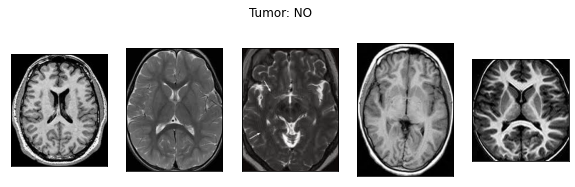

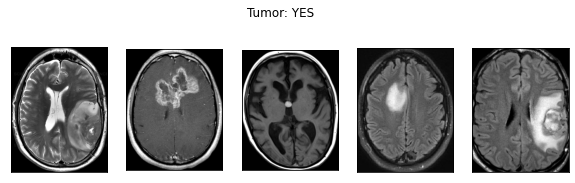

In [35]:
plot_samples(X_train_crop, y_train, labels, 5)

In [0]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1


In [0]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [40]:
from keras.applications.vgg16 import VGG16, preprocess_input

Using TensorFlow backend.


In [0]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [0]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)